In [1]:
# Generic
import os, json, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Modelling
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from lightgbm import LGBMClassifier
# from xgboost import XGBClassifier

In [5]:
print(os.getcwd())
parent_path = './'
sample_submissions = pd.read_csv(parent_path + 'gender_submission.csv', index_col='PassengerId')
sample_submissions.head()

/home/karthic25/Desktop/Programming/titanic


,Survived
PassengerId,
892,0
893,1
894,0
895,0
896,1


# Understanding the dataset

In [184]:
data = pd.read_csv(parent_path + 'train.csv', index_col='PassengerId')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [185]:
print('% Survived:', round(100*data['Survived'].sum()/data.shape[0], 2))

% Survived: 38.38


# Create test-set without empty features

In [186]:
from sklearn.model_selection import train_test_split

# Disconsidering Cabin due to inconsistency
no_missing = data[data['Age'] == data['Age']][data['Embarked'] == data['Embarked']]

num_test_required = int(0.2*data.shape[0])
_, test_data = train_test_split(no_missing, stratify=no_missing['Survived'], test_size=num_test_required, random_state=1)
train_data = data.loc[list(set(data.index) - set(test_data.index))]
train_data.shape, test_data.shape

/tmp/ipykernel_22512/4235784096.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  no_missing = data[data['Age'] == data['Age']][data['Embarked'] == data['Embarked']]


((713, 11), (178, 11))

In [187]:
test_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
284,1,3,"Dorking, Mr. Edward Arthur",male,19.0,0,0,A/5. 10482,8.0500,NaN,S
398,0,2,"McKane, Mr. Peter David",male,46.0,0,0,28403,26.0000,NaN,S
683,0,3,"Olsvigen, Mr. Thor Anderson",male,20.0,0,0,6563,9.2250,NaN,S
249,1,1,"Beckwith, Mr. Richard Leonard",male,37.0,1,1,11751,52.5542,D35,S
293,0,2,"Levy, Mr. Rene Jacques",male,36.0,0,0,SC/Paris 2163,12.8750,D,C


# Feature Engineering

## Creating useful features from "Name"
Title, First Name Contains Bracket are the two features created

In [234]:
def split_name(df):
    # get surname from name
    names = df['Name'].str.split(',', expand=True)
    names.columns = ['Surname', 'Title. First name']
    
    # get title from name
    name_df = names['Title. First name'].str.split('.', expand=True).fillna('')
    if name_df.shape[1] > 2:
        cols = list(range(2, name_df.shape[1]))
        name_df[1] = name_df[[1] + cols].sum(axis=1)
        name_df = name_df.drop(cols, axis=1)
    names['Title'] = name_df[0]
    names['First Name'] = name_df[1]
    names = names.drop('Title. First name', axis=1).applymap(lambda x: x.strip())
    
    # group titles based on relevance
    names['Title'] = names['Title'].replace({
        'Col': 'Army',
        'Ms': 'Miss',
        'Dona': 'Mrs',
        'Mlle': 'Miss',
        'Major': 'Army',
        'the Countess': 'Hon',
        'Sir': 'Hon',
        'Lady': 'Hon',
        'Mme': 'Miss',
        'Don': 'Mr',
        'Jonkheer': 'Hon'
    })
    
    # does name have bracket?
    names['First Name Contains Bracket'] = names['First Name'].apply(lambda x: 1 if '(' in x else 0)
    return pd.concat([df, names], axis=1).drop(['Name', 'First Name', 'Surname'], axis=1)

data_nm = split_name(data)
data_nm

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,First Name Contains Bracket
PassengerId,,,,,,,,,,,,
1,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,0
2,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,1
3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,0
4,1,1,female,35.0,1,0,113803,53.1000,C123,S,Mrs,1
5,0,3,male,35.0,0,0,373450,8.0500,NaN,S,Mr,0
...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,male,27.0,0,0,211536,13.0000,NaN,S,Rev,0
888,1,1,female,19.0,0,0,112053,30.0000,B42,S,Miss,0
889,0,3,female,NaN,1,2,W./C. 6607,23.4500,NaN,S,Miss,0


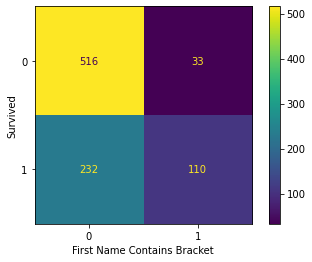

In [243]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_cm(ser1, ser2):
    cm = confusion_matrix(ser1, ser2, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0', '1'])
    fig, ax = plt.subplots()
    disp.plot(ax=ax)
    ax.set_xlabel(ser2.name)
    ax.set_ylabel(ser1.name)
    plt.show()
    
plot_cm(data_nm['Survived'], data_nm['First Name Contains Bracket'])

## Improving Cabin

In [486]:
def improv_cabin(df):
    df = df.copy()
    df['Cabin'] = df['Cabin'].apply(lambda x: x.strip()[0] if isinstance(x, str) else 'NA')
    df['Cabin'] = df['Cabin'].replace({
        'B': 'BCD',
        'C': 'BCD',
        'D': 'BCD',
        'E': 'EFG',
        'F': 'EFG',
        'G': 'EFG'
    })
    return df

data_cb = improv_cabin(data_nm)
data_cb['Cabin'].value_counts().sort_index()

A       15
BCD    139
EFG     49
NA     687
T        1
Name: Cabin, dtype: int64

In [238]:
data_cb

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,First Name Contains Bracket
PassengerId,,,,,,,,,,,,
1,0,3,male,22.0,1,0,A/5 21171,7.2500,NA,S,Mr,0
2,1,1,female,38.0,1,0,PC 17599,71.2833,C,C,Mrs,1
3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NA,S,Miss,0
4,1,1,female,35.0,1,0,113803,53.1000,C,S,Mrs,1
5,0,3,male,35.0,0,0,373450,8.0500,NA,S,Mr,0
...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,male,27.0,0,0,211536,13.0000,NA,S,Rev,0
888,1,1,female,19.0,0,0,112053,30.0000,B,S,Miss,0
889,0,3,female,NaN,1,2,W./C. 6607,23.4500,NA,S,Miss,0


## Dropping Ticket

In [252]:
data_tc = data_cb.drop('Ticket', axis=1)
data_tc

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title,First Name Contains Bracket
PassengerId,,,,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,NA,S,Mr,0
2,1,1,female,38.0,1,0,71.2833,C,C,Mrs,1
3,1,3,female,26.0,0,0,7.9250,NA,S,Miss,0
4,1,1,female,35.0,1,0,53.1000,C,S,Mrs,1
5,0,3,male,35.0,0,0,8.0500,NA,S,Mr,0
...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,male,27.0,0,0,13.0000,NA,S,Rev,0
888,1,1,female,19.0,0,0,30.0000,B,S,Miss,0
889,0,3,female,NaN,1,2,23.4500,NA,S,Miss,0


# One-hot encoding

In [340]:
def dummy_var(transformed, var):
    for sv in set(transformed[var]):
        if sv != sv:
            continue
        transformed[var + '_' + sv] = [1 if v == sv else 0 for v in transformed[var]]
    transformed.drop(var, axis=1, inplace=True)

def transform(df):
    transformed = df.copy()
    dummy_var(transformed, 'Title')
    dummy_var(transformed, 'Sex')
    dummy_var(transformed, 'Cabin')
    dummy_var(transformed, 'Embarked')
    transformed['Pclass'] = transformed['Pclass'].apply(str)
    dummy_var(transformed, 'Pclass')
    return transformed

data_tr = transform(data_tc)
data_tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Survived                     891 non-null    int64  
 1   Age                          714 non-null    float64
 2   SibSp                        891 non-null    int64  
 3   Parch                        891 non-null    int64  
 4   Fare                         891 non-null    float64
 5   First Name Contains Bracket  891 non-null    int64  
 6   Title_Capt                   891 non-null    int64  
 7   Title_Rev                    891 non-null    int64  
 8   Title_Army                   891 non-null    int64  
 9   Title_Mr                     891 non-null    int64  
 10  Title_Miss                   891 non-null    int64  
 11  Title_Dr                     891 non-null    int64  
 12  Title_Hon                    891 non-null    int64  
 13  Title_Master        

# Imputing missing values

## Imputing age

In [341]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5)
X = data_tr.drop(['Survived'], axis=1)
X_im = imputer.fit_transform(X)
X_im = pd.DataFrame(X_im, index=X.index, columns=X.columns)
X_im.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 29 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Age                          891 non-null    float64
 1   SibSp                        891 non-null    float64
 2   Parch                        891 non-null    float64
 3   Fare                         891 non-null    float64
 4   First Name Contains Bracket  891 non-null    float64
 5   Title_Capt                   891 non-null    float64
 6   Title_Rev                    891 non-null    float64
 7   Title_Army                   891 non-null    float64
 8   Title_Mr                     891 non-null    float64
 9   Title_Miss                   891 non-null    float64
 10  Title_Dr                     891 non-null    float64
 11  Title_Hon                    891 non-null    float64
 12  Title_Master                 891 non-null    float64
 13  Title_Mrs           

# Bucketing

## Bucket Age

<AxesSubplot:>

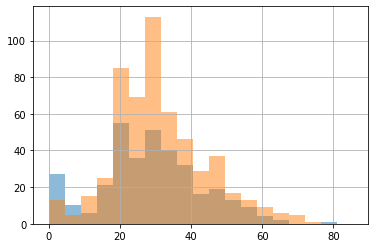

In [369]:
sur = y[y == 1].index
not_sur = y[y == 0].index
bins = [i*4.5 for i in range(20)]
X_im.loc[sur, 'Age'].hist(alpha=0.5, bins=bins)
X_im.loc[not_sur, 'Age'].hist(alpha=0.5, bins=bins)

In [372]:
X_ag = X_im.copy()
cut_age = pd.cut(X_ag['Age'], bins=bins)
X_ag['Age'], _ = pd.factorize(cut_age, sort=True)
X_ag['Age'].value_counts().sort_index()

0      40
1      23
2      13
3      72
4     116
5     121
6     146
7     123
8      58
9      55
10     44
11     38
12     14
13     15
14      6
15      5
16      1
17      1
Name: Age, dtype: int64

# Drop Sex since Title captures it

In [373]:
X_sx = X_ag.drop(['Sex_male', 'Sex_female'], axis=1)
X_sx.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 27 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Age                          891 non-null    int64  
 1   SibSp                        891 non-null    float64
 2   Parch                        891 non-null    float64
 3   Fare                         891 non-null    float64
 4   First Name Contains Bracket  891 non-null    float64
 5   Title_Capt                   891 non-null    float64
 6   Title_Rev                    891 non-null    float64
 7   Title_Army                   891 non-null    float64
 8   Title_Mr                     891 non-null    float64
 9   Title_Miss                   891 non-null    float64
 10  Title_Dr                     891 non-null    float64
 11  Title_Hon                    891 non-null    float64
 12  Title_Master                 891 non-null    float64
 13  Title_Mrs           

In [514]:
def transform_data(data):
    data_nm = split_name(data)
    data_cb = improv_cabin(data_nm)
    data_tc = data_cb.drop('Ticket', axis=1)
    data_tr = transform(data_tc)
    
    imputer = KNNImputer(n_neighbors=5)
    y  = data_tr['Survived']
    X = data_tr.drop(['Survived'], axis=1)
    X_im = imputer.fit_transform(X)
    X_im = pd.DataFrame(X_im, index=X.index, columns=X.columns)
    
    cut_age = pd.cut(X_im['Age'], bins=bins)
    X_im['Age'], _ = pd.factorize(cut_age, sort=True)
    
    X_sx = X_im.drop(['Sex_male', 'Sex_female'], axis=1)
    
    return X_sx, y

X_sx, y = transform_data(pd.concat([data, real_test_data]))

In [515]:
X_sx.shape, y.shape

((1309, 25), (1309,))

In [516]:
X_train, X_test = X_sx.loc[train_data.index], X_sx.loc[test_data.index]
y_train, y_test = y.loc[train_data.index], y.loc[test_data.index]
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((713, 25), (178, 25), (713,), (178,))

In [517]:
param_grid = {}
param_grid['svc'] = {
    'C': [i for i in np.linspace(0.1,30,20)], 
    'degree': [2,3,4],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}
param_grid['rfc'] = {
    'bootstrap': [True],
    'max_depth': [6, 8, 11, 15],
    'max_features': [10, 20],
    'criterion': ['gini'],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [6, 8, 10],
    'max_leaf_nodes': [100, None],
    'n_estimators': [200, 500],
    'class_weight': ['balanced']
}
param_grid['xgb'] = {
    'learning_rate': [0.05, 0.5, 5, 50], #so called `eta` value
    'max_depth': [4, 10, 20, 40],
    'min_child_weight': [3, 5, 9],
    'silent': [1, 2, 4, 9],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.7],
    'n_estimators': [5, 10, 50, 100], #number of trees, change it to 1000 for better results
}
param_grid['lgbm'] = {
    'num_leaves': [2, 3, 5, 10],
    'reg_alpha': [0.1, 0.5],
    'min_data_in_leaf': [10, 30, 50, 100, 300],
    'lambda_l1': [0, 1, 1.5],
    'lambda_l2': [0, 1],
    'max_depth': [int(i*2) for i in np.logspace(0,1.7,10)]
}
params = {
    'bootstrap': False,
    'ccp_alpha': 0.0,
    'class_weight': 'balanced',
    'criterion': 'gini',
    'max_depth': 15,
    'max_features': 10,
    'max_leaf_nodes': 50,
    'max_samples': None,
    'min_impurity_decrease': 0.0,
    'min_impurity_split': None,
    'min_samples_leaf': 3,
    'min_samples_split': 6,
    'min_weight_fraction_leaf': 0.0,
    'n_estimators': 500,
    'n_jobs': None,
    'oob_score': False,
    'random_state': 1,
    'verbose': 0,
    'warm_start': False
}

param_grid['rfc']

{'bootstrap': [True],
 'max_depth': [6, 8, 11, 15],
 'max_features': [10, 20],
 'criterion': ['gini'],
 'min_samples_leaf': [3, 4, 5],
 'min_samples_split': [6, 8, 10],
 'max_leaf_nodes': [100, None],
 'n_estimators': [200, 500],
 'class_weight': ['balanced']}

In [511]:
from sklearn.metrics import recall_score, precision_score, f1_score

def predict(model, X):
    y_pred = model.predict(X)
    y_pred = pd.Series(y_pred, index=X.index)
    return y_pred

def get_results(y_true, y_pred):
    results = {}
    results['Accuracy'] = accuracy_score(y_true, y_pred)
    results['Recall'] = recall_score(y_true, y_pred)
    results['Precision'] = precision_score(y_true, y_pred)
    results['F1'] = f1_score(y_true, y_pred)
    return pd.Series(results)*100

def get_train_test_results(y_train, y_train_pred, y_test, y_test_pred):
    return pd.concat([
        get_results(y_train, y_train_pred),
        get_results(y_test, y_test_pred)
    ], axis=1, keys=['Train', 'Test']).round(2)


rf = RandomForestClassifier(**params)
model = GridSearchCV(rf, param_grid=param_grid['rfc'], n_jobs=-1, scoring='accuracy', verbose=1)
model.fit(pd.concat([X_train, X_test]), pd.concat([y_train, y_test]))
# model.fit(X_train, y_train)

y_train_pred = predict(model, X_train)
y_test_pred = predict(model, X_test)

get_train_test_results(y_train, y_train_pred, y_test, y_test_pred)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


,Train,Test
Accuracy,89.48,87.64
Recall,85.56,84.72
Precision,86.52,84.72
F1,86.03,84.72


In [513]:
real_test_pred = model.predict(X_sx.loc[real_test_data.index])
real_test_pred = pd.Series(real_test_pred, index=real_test_data.index).apply(int)
real_test_pred.name = 'Survived'
real_test_pred.to_csv('./submission.csv')
real_test_pred

PassengerId
892     0
893     0
894     0
895     0
896     1
       ..
1305    0
1306    1
1307    0
1308    0
1309    1
Name: Survived, Length: 418, dtype: int64

In [450]:
real_test_data['Pclass'].value_counts()

3    218
1    107
2     93
Name: Pclass, dtype: int64

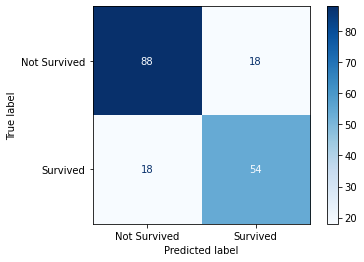

In [508]:
from sklearn.metrics import plot_confusion_matrix
disp = plot_confusion_matrix(model, X_test, y_test, display_labels=['Not Survived', 'Survived'],cmap=plt.cm.Blues)
plt.show()

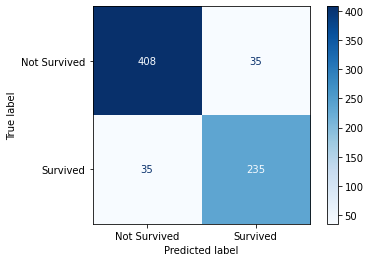

In [509]:
disp = plot_confusion_matrix(model, X_train, y_train, display_labels=['Not Survived', 'Survived'],cmap=plt.cm.Blues)
plt.show()

<AxesSubplot:>

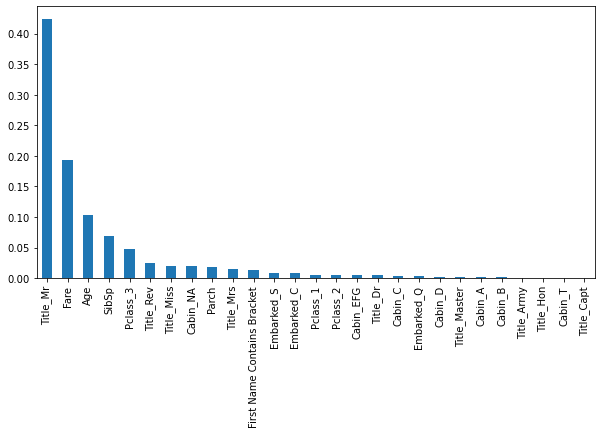

In [380]:
ft_imp = pd.Series(model.feature_importances_, index=X_train.columns)
ft_imp.sort_values(ascending=False).plot.bar(figsize=(10, 5))

In [390]:
ser = (y_train_pred != y_train)
inc = ser[ser == True].index
data.loc[inc]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
15,0,3,"Vestrom, Miss. Hulda Amanda Adolfina",female,14.0,0,0,350406,7.8542,NaN,S
18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
19,0,3,"Vander Planke, Mrs. Julius (Emelia Maria Vande...",female,31.0,1,0,345763,18.0000,NaN,S
26,1,3,"Asplund, Mrs. Carl Oscar (Selma Augusta Emilia...",female,38.0,1,5,347077,31.3875,NaN,S
37,1,3,"Mamee, Mr. Hanna",male,NaN,0,0,2677,7.2292,NaN,C
...,...,...,...,...,...,...,...,...,...,...,...
823,0,1,"Reuchlin, Jonkheer. John George",male,38.0,0,0,19972,0.0000,NaN,S
827,0,3,"Lam, Mr. Len",male,NaN,0,0,1601,56.4958,NaN,S
829,1,3,"McCormack, Mr. Thomas Joseph",male,NaN,0,0,367228,7.7500,NaN,Q


In [415]:
data.loc[inc].value_counts('Pclass')/data.value_counts('Pclass')

Pclass
3    0.089613
1    0.064815
2    0.065217
dtype: float64

In [416]:
data.loc[inc].value_counts('Sex')/data.value_counts('Sex')

Sex
male      0.077990
female    0.079618
dtype: float64

In [420]:
data.loc[inc].value_counts('Embarked')/data.value_counts('Embarked')

Embarked
S    0.076087
C    0.071429
Q    0.116883
dtype: float64

In [410]:
X_train.loc[inc]['First Name Contains Bracket'].sum()/70

0.2

In [421]:
data.loc[inc].value_counts('Survived')/data.value_counts('Survived')

Survived
0    0.054645
1    0.116959
dtype: float64

In [430]:
pos = data[data['Survived'] == 1].index
data.loc[list(set(inc) & set(pos))]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
262,1,3,"Asplund, Master. Edvin Rojj Felix",male,3.0,4,2,347077,31.3875,NaN,S
391,1,1,"Carter, Mr. William Ernest",male,36.0,1,2,113760,120.0000,B96 B98,S
392,1,3,"Jansson, Mr. Carl Olof",male,21.0,0,0,350034,7.7958,NaN,S
268,1,3,"Persson, Mr. Ernst Ulrik",male,25.0,1,0,347083,7.7750,NaN,S
272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0000,NaN,S
18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
665,1,3,"Lindqvist, Mr. Eino William",male,20.0,1,0,STON/O 2. 3101285,7.9250,NaN,S
26,1,3,"Asplund, Mrs. Carl Oscar (Selma Augusta Emilia...",female,38.0,1,5,347077,31.3875,NaN,S
415,1,3,"Sundman, Mr. Johan Julian",male,44.0,0,0,STON/O 2. 3101269,7.9250,NaN,S


<AxesSubplot:>

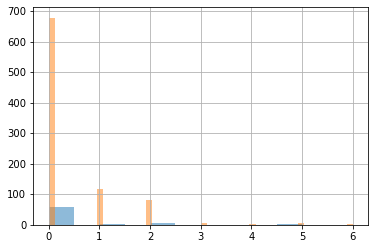

In [419]:
ft = 'Parch'
data.loc[inc, ft].hist(alpha=0.5, bins=10)
data.loc[:, ft].hist(alpha=0.5, bins=50)

In [166]:
for model in clf:
    print('Model:',model, '; Accuracy score:', accuracy_score(clf[model].y_test, clf[model].y_pred))

Model: svc ; Accuracy score: 0.8044692737430168
Model: rfc ; Accuracy score: 0.8100558659217877
Model: xgb ; Accuracy score: 0.8156424581005587
Model: lgbm ; Accuracy score: 0.8156424581005587


In [167]:
for model in clf:
    print('Model:',model, '; Accuracy score:', accuracy_score(clf[model].y_train, clf[model].y_pred_train))

Model: svc ; Accuracy score: 0.8328651685393258
Model: rfc ; Accuracy score: 0.8707865168539326
Model: xgb ; Accuracy score: 0.9213483146067416
Model: lgbm ; Accuracy score: 0.9044943820224719


In [141]:
test = pd.read_csv('test.csv')
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [142]:
test_transformed = transform(test)
test_transformed['Fare'] = test_transformed['Fare'].fillna(0)
extra_columns = [col for col in transformed.columns if col not in test_transformed.columns]
print(extra_columns)
for col in extra_columns:
    if col != 'Survived':
        test_transformed[col] = [0]*test_transformed.shape[0]
redundant_columns  = [col for col in test_transformed.columns if col not in transformed.columns]
print(redundant_columns)
for col in redundant_columns:
    test_transformed.drop(col, axis=1, inplace=True)
test_transformed.info()

['Survived', 'Title_Capt.', 'Title_Mme.', 'Title_Mlle.', 'Title_Don.', 'Title_Sir.', 'Title_Major.', 'Title_Lady.', 'Title_the', 'Title_Jonkheer.', 'Cabin_Level_T', 'Embarked_N']
['Title_Dona.']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 38 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PassengerId      418 non-null    int64  
 1   Pclass           418 non-null    int64  
 2   Age              418 non-null    float64
 3   SibSp            418 non-null    int64  
 4   Parch            418 non-null    int64  
 5   Fare             418 non-null    float64
 6   Title_Mr.        418 non-null    int64  
 7   Title_Miss.      418 non-null    int64  
 8   Title_Dr.        418 non-null    int64  
 9   Title_Ms.        418 non-null    int64  
 10  Title_Col.       418 non-null    int64  
 11  Title_Mrs.       418 non-null    int64  
 12  Title_Master.    418 non-null    int64  
 13  Title

In [146]:
y = clf['xgb'].clf.predict(test_transformed[clf[model].X_test.columns])
y

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [147]:
pd.DataFrame({'PassengerId':test_transformed['PassengerId'], 'Survived':y}).to_csv('predict.csv', index=False)